In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import CubicSpline
from scipy.linalg import lu

In [2]:
f =  ScalarFormatter(useOffset=False, useMathText=True)
f.set_scientific(True)
f.set_powerlimits((0, 0))

def sci_notation(x):
    if x == 0:
        return "0"
    else:
        formatted = f"{x:.2e}"  # Converte in notazione scientifica
        coefficient, exponent = formatted.split('e')
        exponent = int(exponent)  # Converti l'esponente a intero
        return f"${coefficient} \\times 10^{{{exponent}}}$"  # Notazione LaTeX

In [3]:
K = 1.380649e-23 # J / K
vc = 299792458 #m / s
h_pl = 6.62607015e-34 #J*s
T = 2.72548 #K

z1 = np.geomspace(1.0e+2,5.0e+6,500)

In [4]:
folder = 'fullgreen3/batch/PDE-non-linear'
x = []
DT = []
DI_N = []
DI = []

for i in range (len(z1)):
    if ((i>8) and (i<99)):
        file_path = os.path.join(folder, f"Dn.delta-z_z_heat_0{i+1}.dat")
    elif(i<9):
        file_path = os.path.join(folder, f"Dn.delta-z_z_heat_00{i+1}.dat")
    else:
        file_path = os.path.join(folder, f"Dn.delta-z_z_heat_{i+1}.dat")
        
    op = pd.read_csv(file_path, skiprows=6, delimiter=' ', header=None)


    a = op.iloc[:, 0].values
    x.append(a)
    b = op.iloc[:, 4].values
    DT.append(b)
    c = op.iloc[:, 5].values
    DI.append(c)
    e = op.iloc[:, 6].values
    DI_N.append(e)

8


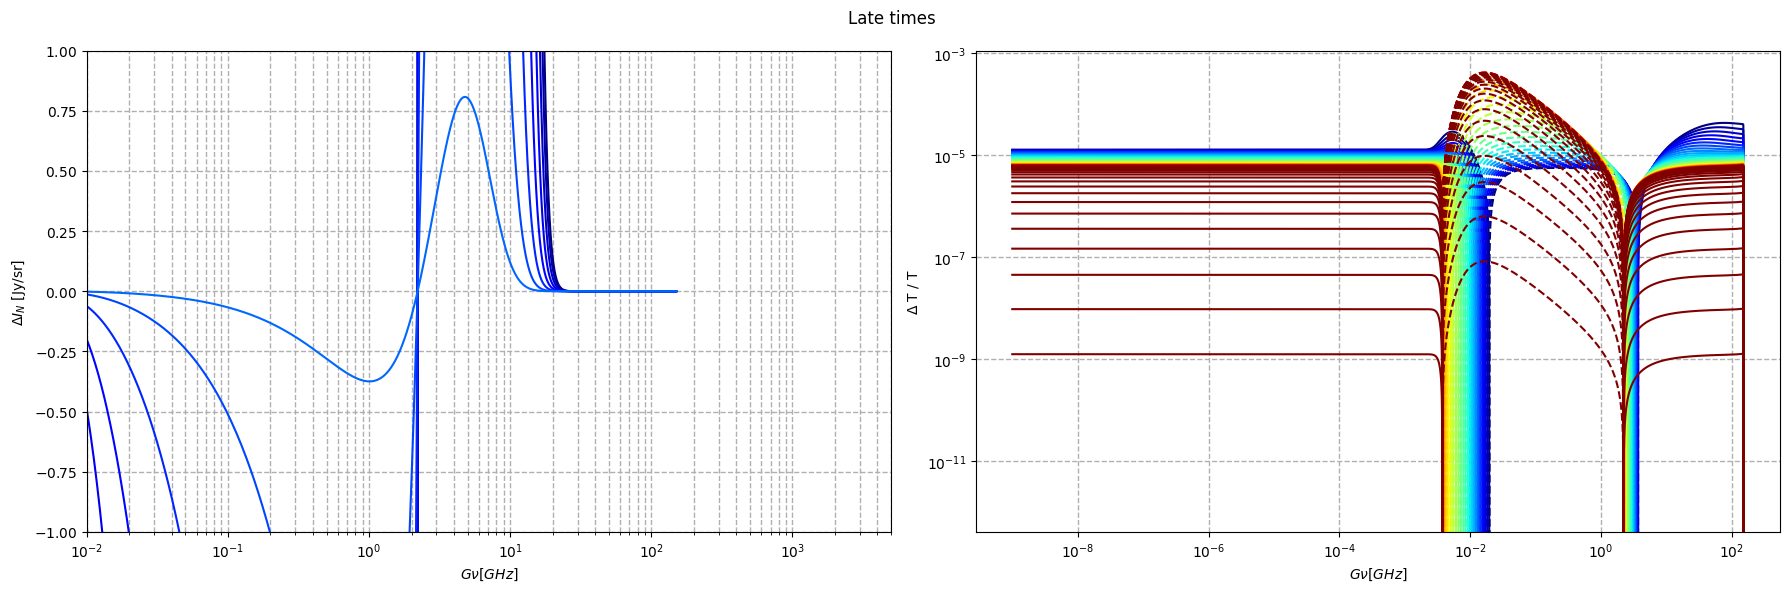

In [26]:
colors = plt.colormaps['jet'].resampled(32)

# Crea la figura e i subplots (2 righe e 1 colonna)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"Late times ")

# Plot per DI_N2 (primo subplot)
col=0
for i in range(len(z1)):
    if((z1[i]>2e6) and (i%5==0)):
        ax1.plot(x[i], DI[i], label=f"z = {sci_notation(z1[i])}", color = colors(col))
        col +=1
print(col)

ax1.set_xscale('log')
ax1.set_xlim([1e-2, 5e+3])
ax1.set_ylim([-0.01e2, +0.01e2])
ax1.set_ylabel("$\Delta I_{N}$ [Jy/sr]")
ax1.set_xlabel("$G\\nu [GHz]$")
#ax1.set_title("All $\Delta$ I_N curves")
ax1.grid(True, which = 'both',  linestyle='--', linewidth=1)
#ax1.legend()

# Plot per DT2 (secondo subplot)
col = 0
for i in range(len(z1)):
    if((z1[i]>20000) and (i%5==0)):
        ax2.plot(x[i], DT[i], color = colors(col))
        ax2.plot(x[i], -DT[i], color = colors(col), linestyle= "dashed")
        col += 1



ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.set_xlim([1e-9, 1e-7])
#ax2.set_ylim([-0.5e-3, 3e+3])
ax2.set_ylabel("$\Delta$ T / T")
ax2.set_xlabel("$G\\nu [GHz]$")
ax2.grid(True, which = 'both',  linestyle='--', linewidth=1)
#ax2.legend()

ax1.yaxis.set_major_formatter(ScalarFormatter())    
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0),useMathText=True) #only y axis, it does not work on the log scale
#ax2.yaxis.set_major_formatter(ScalarFormatter())
#ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0),useMathText=True) 
# Aggiusta il layout
plt.tight_layout()
plt.show()

In [5]:
# note that these are the enrgy density functions, should be multiplied by the correct factor in the front

G = lambda x: x**4*np.exp(x)/(np.exp(x)-1)**2 * (2*K**3*T**3)/(vc**2*h_pl**2)
Y = lambda x: G(x) * ( x* (np.exp(x)+1)/(np.exp(x)-1)-4 ) 
M = lambda x: G(x)* (0.4561-1.0/x) 

Jrefm= lambda x:   (1-np.exp(-((1+x)/5.8e4)**1.88))*np.exp(-(x/1.98e+6)**(5/2)) 
Jrefy= lambda x:  1/(1+((1+x)/6e4)**2.58)

rho_tot = 1e-5

In [6]:

DI_Nspl = []
for i in range(len(z1)):
    DI_Nspl.append(CubicSpline(x[i], DI_N[i]*1e-26))

DI_spl = []
for i in range(len(z1)):
    DI_spl.append(CubicSpline(x[i], DI[i]*1e-26))


In [7]:
#compute the functions on the given grid

x1 = np.arange(30,1000,15)
x1 = h_pl*x1/(K*T)*1e9

#x1 = np.arange(5,1000,1)
#x1 = h_pl*x1/(K*T)*1e9
#
#x1 = np.arange(30,1000,1)
#x1 = h_pl*x1/(K*T)*1e9

In [8]:
Y_spl = CubicSpline(x1, Y(x1))   #interpolate
M_spl = CubicSpline(x1, M(x1))
G_spl = CubicSpline(x1, G(x1))

In [9]:
ncol = 3
nrow = 3
A = [[0 for _ in range(ncol)] for _ in range(nrow)]
B = [[0 for _ in range(1)] for _ in range(nrow)]
sol = [[0 for _ in range(ncol)] for _ in range(len(z1))]



rho_mu = np.zeros(len(z1))
rho_y  = np.zeros(len(z1))
rho_T  = np.zeros(len(z1))

I_y  = np.zeros(len(z1))
I_mu = np.zeros(len(z1))
I_T  = np.zeros(len(z1))

In [10]:
np.inner(Y(x1) , Y(x1))/(1e-18)**2
np.inner(G(x1) , G(x1))/(1e-18)**2
np.inner(M(x1) , Y(x1))/(1e-18)**2

561.1009985993278

In [11]:

A[0][0] = np.inner(Y_spl(x1) , Y_spl(x1))
A[0][1] = np.inner(M_spl(x1) , Y_spl(x1))
A[0][2] = np.inner(G_spl(x1) , Y_spl(x1))
A[1][0] = np.inner(Y_spl(x1) , M_spl(x1))
A[1][1] = np.inner(M_spl(x1) , M_spl(x1))
A[1][2] = np.inner(G_spl(x1) , M_spl(x1))
A[2][0] = np.inner(Y_spl(x1) , G_spl(x1))
A[2][1] = np.inner(M_spl(x1) , G_spl(x1))
A[2][2] = np.inner(G_spl(x1) , G_spl(x1))

#A2[0][1] = np.inner(M_spl(x2) , Y_spl(x2))
#A2[0][0] = np.inner(Y_spl(x2) , Y_spl(x2))
#A2[0][2] = np.inner(G_spl(x2) , Y_spl(x2))
#A2[1][0] = np.inner(Y_spl(x2) , M_spl(x2))
#A2[1][1] = np.inner(M_spl(x2) , M_spl(x2))
#A2[1][2] = np.inner(G_spl(x2) , M_spl(x2))
#A2[2][0] = np.inner(Y_spl(x2) , G_spl(x2))
#A2[2][1] = np.inner(M_spl(x2) , G_spl(x2))
#A2[2][2] = np.inner(G_spl(x2) , G_spl(x2))
#A3[0][0] = np.inner(Y_spl(x3) , Y_spl(x3))
#A3[0][1] = np.inner(M_spl(x3) , Y_spl(x3))
#
#A3[0][2] = np.inner(G_spl(x3) , Y_spl(x3))
#A3[1][0] = np.inner(Y_spl(x3) , M_spl(x3))
#A3[1][1] = np.inner(M_spl(x3) , M_spl(x3))
#A3[1][2] = np.inner(G_spl(x3) , M_spl(x3))
#A3[2][0] = np.inner(Y_spl(x3) , G_spl(x3))
#A3[2][1] = np.inner(M_spl(x3) , G_spl(x3))
#A3[2][2] = np.inner(G_spl(x3) , G_spl(x3))

In [12]:
for i in range (len(z1)):    #i is the injection redshift
   
       
    B[0][0] = np.inner(DI_spl[i](x1) , Y_spl(x1))
    B[1][0] = np.inner(DI_spl[i](x1) , M_spl(x1))
    B[2][0] = np.inner(DI_spl[i](x1) , G_spl(x1))


    sol[i][:]=np.linalg.solve(A,B)


    rho_y[i] = sol[i][0]*4.
    rho_mu[i] = sol[i][1]/1.401
    rho_T[i] = sol[i][2]*4
      

    I_mu [i] = rho_mu [i] / rho_tot
    I_y [i] = rho_y[i] / rho_tot
    I_T [i] = rho_T[i] / rho_tot


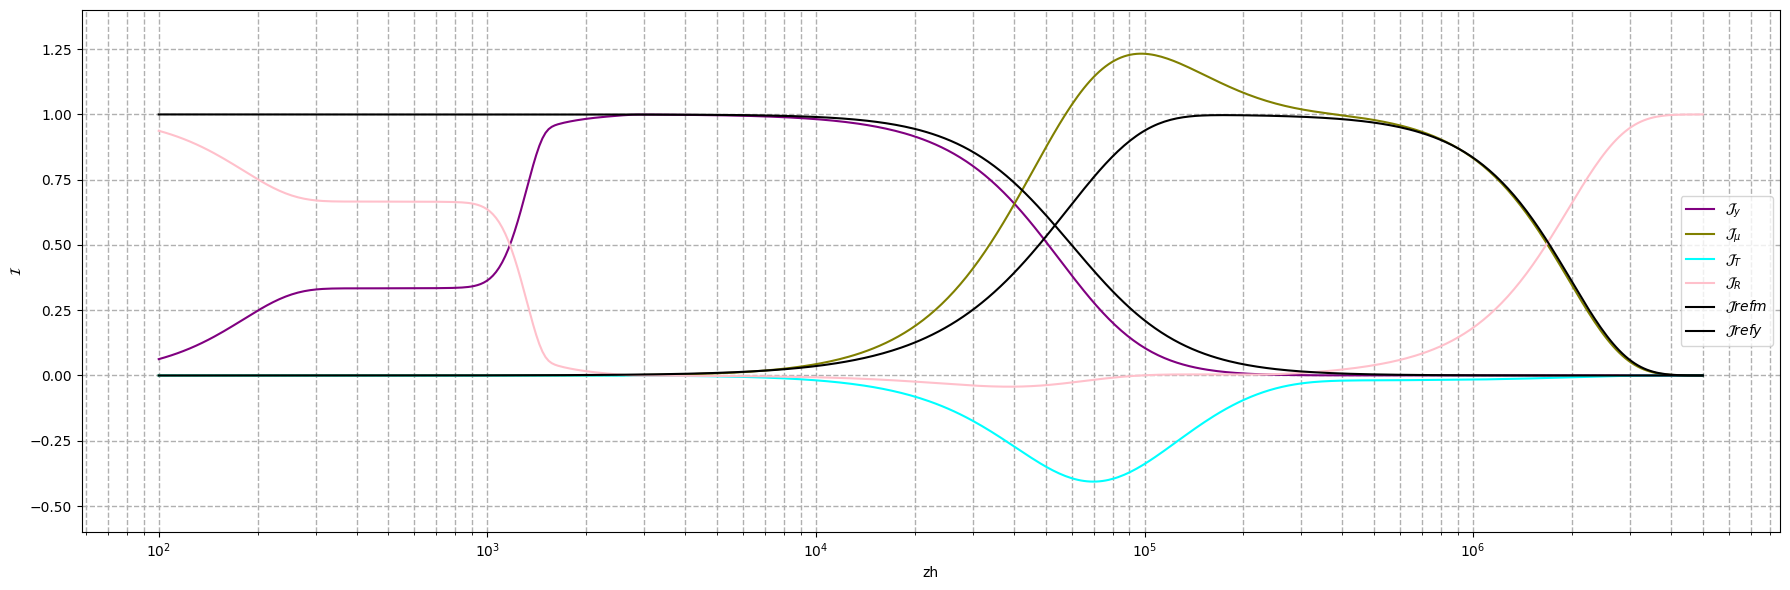

In [13]:

fig, ax = plt.subplots( figsize=(18, 6))


ax.plot(z1, I_y, color = "purple", label= "$\mathcal{J}_y$")
#ax.plot(z1, -I_y, color = "purple",linestyle = "dashed")
ax.plot(z1, I_mu, color = "olive",label= "$\mathcal{J}_{\mu}$")
#ax.plot(z1, -I_mu, color = "olive", linestyle = "dashed")
ax.plot(z1, I_T, color = "cyan",label= "$\mathcal{J}_{T}$")
#ax.plot(z1, -I_T, color = "cyan", linestyle = "dashed")

ax.plot(z1, 1-(I_T+I_y+I_mu), color = "pink",label= "$\mathcal{J}_{R}$")
#ax.plot(z1, -(1-I_T-I_y-I_mu), color = "pink", linestyle = "dashed")


ax.plot(z1, Jrefm(z1), color = "black",label="$\mathcal{J}ref m $")
#ax.plot(z1, -Jrefm(z1), color = "black",linestyle = "dashed")


ax.plot(z1, Jrefy(z1), color = "black",label="$\mathcal{J}ref y $")
#ax.plot(z1, -Jrefy(z1), color = "black",linestyle = "dashed")


ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim([-0.6,1.4])
#ax.set_ylim([1e-5,10])
ax.set_ylabel("$\mathcal{I}$")
ax.set_xlabel("zh")
#ax1.set_title("All $\Delta$ I_N curves")
ax.grid(True, which = 'both',  linestyle='--', linewidth=1)
ax.legend()





#ax.yaxis.set_major_formatter(ScalarFormatter())    
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0),useMathText=True) #only y axis, it does not work on the log scale

plt.tight_layout()
plt.show()